In [1]:
# Importando bibliotecas

import os
import wfdb
import numpy as np
from scipy.signal import find_peaks
from scipy.stats import skew, kurtosis

import matplotlib.pyplot as plt

In [2]:
# Definindo funções

# --------------------------------------------
## Plotar sinal de ECG com os picos detectados

def plot_detected_peaks(t, ecg_signal, detected_peaks):
    # Plotar os sinais original e filtrado com os picos QRS detectados
    plt.figure(figsize=(12, 8))
    plt.plot(t, ecg_signal, label='Sinal original', alpha=0.7)
    plt.scatter(t[detected_peaks], ecg_signal[detected_peaks], color='red', marker='o', label='Picos QRS')
    plt.title('Sinal de ECG com Picos R Detectados')
    plt.vlines(t[detected_peaks], *plt.ylim(), label="Picos", color=".2", alpha=0.3, ls="--")
    plt.xlabel('Tempo (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

# --------------------------------------------
## Indices de qualidade

def compute_iSQI(detected_peaks, total_beats):
    return len(detected_peaks) / total_beats * 100

def compute_fSQI(ecg_signal, sampling_rate=1000):
    fn = 0.5 * sampling_rate  # Frequência de Nyquist
    power_5_20Hz = np.sum(np.square(ecg_signal[(5 <= fn) & (fn <= 20)]))
    power_0_fnHz = np.sum(np.square(ecg_signal[fn <= 0.5 * sampling_rate]))
    return power_5_20Hz / power_0_fnHz

def compute_sSQI(ecg_signal):
    return skew(ecg_signal)

def compute_kSQI(ecg_signal):
    return kurtosis(ecg_signal)

def compute_pSQI(ecg_signal, epsilon=1.0):
    dxm_dt = np.gradient(ecg_signal)
    flat_line_percentage = np.sum(np.abs(dxm_dt) < epsilon) / len(ecg_signal) * 100
    return flat_line_percentage

def get_quality_indexes(peaks, t, ecg_signal):
    # Calcular índices de qualidade
    iSQI_value = compute_iSQI(peaks, len(t))
    fSQI_value = compute_fSQI(ecg_signal)
    sSQI_value = compute_sSQI(ecg_signal)
    kSQI_value = compute_kSQI(ecg_signal)
    pSQI_value = compute_pSQI(ecg_signal)
    return [iSQI_value, fSQI_value, sSQI_value, kSQI_value, pSQI_value]


In [3]:
# Diretório que contém os arquivos .hea e .dat
diretorio = 'C:/Users/estela.ribeiro/JupyterNotebooks/ECGcodes/set-a/'


In [4]:
# Gerando o dataset

# Lista para armazenar os sinais, nomes de arquivo e classes
df_ecg_cinc2011 = []

# Lê os nomes dos pacientes da classe 'positiva' a partir do arquivo .txt
with open(diretorio + 'RECORDS-acceptable', 'r') as file_positivo:
    boa_qualidade = [line.strip() for line in file_positivo]

# Lê os nomes dos pacientes da classe 'negativa' a partir do arquivo .txt
with open(diretorio + 'RECORDS-unacceptable', 'r') as file_negativo:
    ma_qualidade = [line.strip() for line in file_negativo]

# Itera sobre todos os arquivos no diretório
for arquivo in os.listdir(diretorio):
    if arquivo.endswith('.hea'):
        # Extrai o nome do arquivo sem a extensão
        nome_base = os.path.splitext(arquivo)[0]

        # Carrega as informações do cabeçalho (.hea)
        record = wfdb.rdheader(os.path.join(diretorio, nome_base))

        # Carrega os dados do sinal (.dat)
        signals, _ = wfdb.rdsamp(os.path.join(diretorio, nome_base))
        
        # Como vou usar apenas a DII, seleciono apenas essa derivação
        ecg_signal = signals[:,1]

        # Determina a classe do paciente
        if nome_base in boa_qualidade:
            classe = 'bom'
        elif nome_base in ma_qualidade:
            classe = 'ruim'
        else:
            classe = np.nan
        
        # Identifica os picos nos sinais de ECG
        sampling_rate = record.fs
        duration = 10 # segundos
        t = np.arange(0, duration, 1/sampling_rate)
        peaks, _ = find_peaks(ecg_signal, height = 0.2, distance = sampling_rate/2)
        
        # Gera os indices de qualidade
        indices = get_quality_indexes(peaks, t, ecg_signal)
        
        #plot_detected_peaks(t, ecg_signal, peaks) # Deixar comentado essa linha para não gerar os plots

        # Adiciona os sinais, informações adicionais e a classe à lista
        df_ecg_cinc2011.append({'Paciente': nome_base, 'Sinais': ecg_signal, 'Frequencia de Amostragem': record.fs, 'Classe': classe, 'Picos': peaks, 'Features': indices})

C:\Users\ESTELA~1.RIB\AppData\Local\Temp/ipykernel_15516/3927167935.py:28: RuntimeWarning: invalid value encountered in double_scalars
  return power_5_20Hz / power_0_fnHz


In [5]:
# VISUALIZANDO RESULTADOS

def show_results(idx):
    paciente = df_ecg_cinc2011[idx]['Paciente']
    classe = df_ecg_cinc2011[idx]['Classe']
    features = df_ecg_cinc2011[idx]['Features']
    ecg = df_ecg_cinc2011[idx]['Sinais']
    picos = df_ecg_cinc2011[idx]['Picos']

    print(f'FILENAME: {paciente}')
    print(f'CLASSE: {classe}')
    print(f'FEATURES: {features}')

    plot_detected_peaks(t, ecg, picos)

In [6]:
# Parâmetros

sampling_rate = 500 # Hz
duration = 10 # segundos
t = np.arange(0, duration, 1/sampling_rate)

FILENAME: 1002867
CLASSE: bom
FEATURES: [0.2, 0.0, -0.46612093186253545, 19.392805175501238, 100.0]


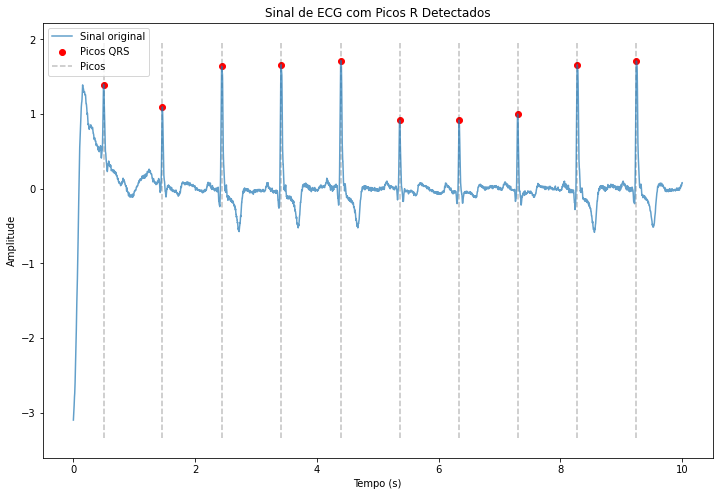

In [7]:
idx = 1
show_results(idx)

FILENAME: 1003574
CLASSE: ruim
FEATURES: [0.16, 0.0, -2.1746740930593185, 9.449453156414261, 100.0]


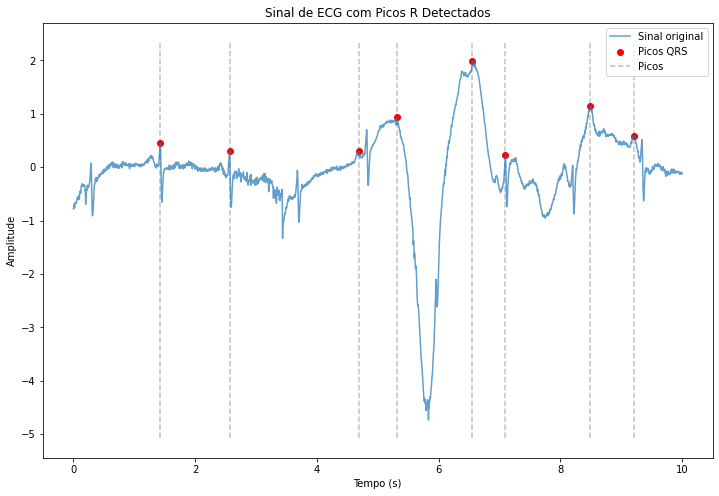

In [8]:
idx = 2
show_results(idx)

FILENAME: 1004502
CLASSE: ruim
FEATURES: [0.3, 0.0, -0.6684783077838481, 2.5350057844554126, 100.0]


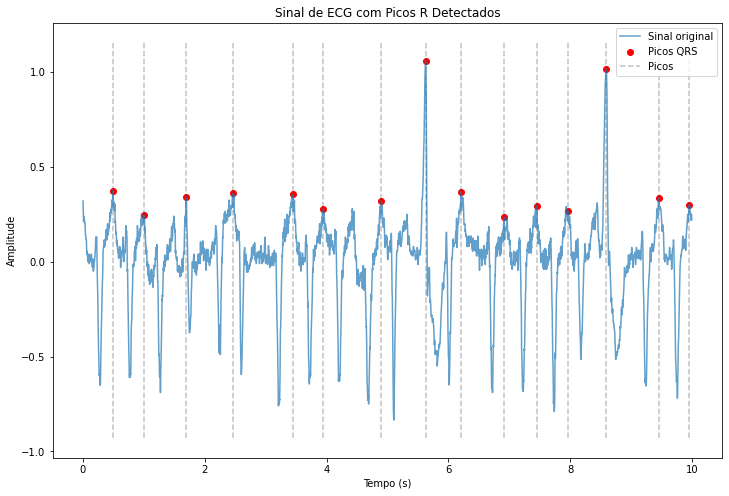

In [9]:
idx = 3
show_results(idx)

FILENAME: 1005639
CLASSE: bom
FEATURES: [0.2, 0.0, 4.419841197862508, 25.069052592851513, 100.0]


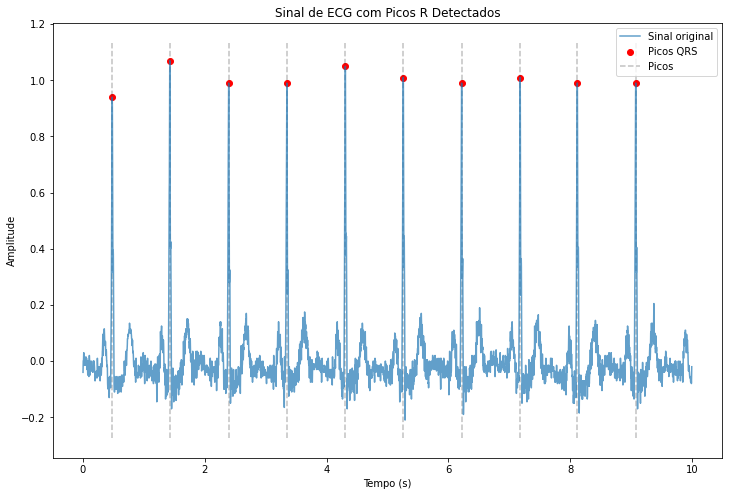

In [10]:
idx = 4
show_results(idx)

## MODELO

In [11]:
import pandas as pd

df_ecg_cinc2011 = pd.DataFrame(df_ecg_cinc2011)

# Seleciona apenas as colunas relevantes (Features e Classe)
df_ecg = df_ecg_cinc2011[['Features', 'Classe']]

df_ecg.head()

,Features,Classe
0,"[0.0, 0.0, 0.0, -3.0, 100.0]",ruim
1,"[0.2, 0.0, -0.46612093186253545, 19.3928051755...",bom
2,"[0.16, 0.0, -2.1746740930593185, 9.44945315641...",ruim
3,"[0.3, 0.0, -0.6684783077838481, 2.535005784455...",ruim
4,"[0.2, 0.0, 4.419841197862508, 25.0690525928515...",bom


In [12]:
df = pd.DataFrame(df_ecg['Features'].tolist(), columns=['iSQI', 'fSQI', 'sSQI', 'kSQI', 'pSQI'])
df['Classe'] = df_ecg['Classe']

In [13]:
df

,iSQI,fSQI,sSQI,kSQI,pSQI,Classe
0,0.00,0.0,0.000000,-3.000000,100.00,ruim
1,0.20,0.0,-0.466121,19.392805,100.00,bom
2,0.16,0.0,-2.174674,9.449453,100.00,ruim
3,0.30,0.0,-0.668478,2.535006,100.00,ruim
4,0.20,0.0,4.419841,25.069053,100.00,bom
...,...,...,...,...,...,...
995,0.04,0.0,4.682297,20.321459,99.56,ruim
996,0.26,0.0,-1.396489,5.821627,100.00,ruim
997,0.24,0.0,3.107946,14.621376,100.00,bom
998,0.24,0.0,3.345171,16.979691,100.00,bom


In [14]:
print(f'NaN? : {pd.isna(df).sum()}')

NaN? : iSQI       0
fSQI      12
sSQI       0
kSQI       0
pSQI       0
Classe     2
dtype: int64


In [15]:
df = df.dropna()

In [16]:
print(f'NaN? : {pd.isna(df).sum()}')

NaN? : iSQI      0
fSQI      0
sSQI      0
kSQI      0
pSQI      0
Classe    0
dtype: int64


In [18]:
# Separa as Features e a Classe
X = df[['iSQI', 'fSQI', 'sSQI', 'kSQI', 'pSQI']]
y = df['Classe']

In [19]:
X.head()

,iSQI,fSQI,sSQI,kSQI,pSQI
0,0.00,0.0,0.000000,-3.000000,100.0
1,0.20,0.0,-0.466121,19.392805,100.0
2,0.16,0.0,-2.174674,9.449453,100.0
3,0.30,0.0,-0.668478,2.535006,100.0
4,0.20,0.0,4.419841,25.069053,100.0


In [20]:
pd.isna(X).sum(), X.shape

(iSQI    0
 fSQI    0
 sSQI    0
 kSQI    0
 pSQI    0
 dtype: int64,
 (986, 5))

In [21]:
y.head()

0    ruim
1     bom
2    ruim
3    ruim
4     bom
Name: Classe, dtype: object

In [22]:
pd.isna(y).sum(), y.shape

(0, (986,))

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [24]:
# Divide o conjunto de dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializa o modelo Random Forest
modelo_rf = RandomForestClassifier(random_state=42)

# Treina o modelo
modelo_rf.fit(X_train, y_train)

# Faz predições no conjunto de teste
predicoes = modelo_rf.predict(X_test)

In [25]:
# Avalia o desempenho do modelo
acuracia = accuracy_score(y_test, predicoes)
relatorio_classificacao = classification_report(y_test, predicoes)
matriz_confusao = confusion_matrix(y_test, predicoes)

# Imprime as métricas de avaliação
print(f'Acurácia: {acuracia}')
print('Relatório de Classificação:')
print(relatorio_classificacao)
print('Matriz de Confusão:')
print(matriz_confusao)

Acurácia: 0.8636363636363636
Relatório de Classificação:
              precision    recall  f1-score   support

         bom       0.87      0.97      0.92       158
        ruim       0.81      0.42      0.56        40

    accuracy                           0.86       198
   macro avg       0.84      0.70      0.74       198
weighted avg       0.86      0.86      0.85       198

Matriz de Confusão:
[[154   4]
 [ 23  17]]


In [26]:
# Obtém a importância das features
importancias_features = modelo_rf.feature_importances_

# Exibe a importância de cada feature
for nome_feature, importancia in zip(X.columns, importancias_features):
    print(f'Importância de {nome_feature}: {importancia}')

Importância de iSQI: 0.18436165735713766
Importância de fSQI: 0.0
Importância de sSQI: 0.2916653445892368
Importância de kSQI: 0.43294236723245066
Importância de pSQI: 0.09103063082117492
